## Sales Prediction with Time Series and XGBoost

### Imports del notebook


In [1110]:
import os

import pandas as pd
import xgboost as xgb

In [1111]:
print(f"pandas version: {pd.__version__}")
print(f"xgboost version: {xgb.__version__}")

pandas version: 2.1.4
xgboost version: 2.1.1


In [1112]:
# if pd.__version__ != "1.5.1":
#     os.system("pip install pandas==1.5.1")

In [1113]:
# if xgb.__version__ != "1.3.3":
#     os.system("pip install xgboost==1.3.3")

In [1114]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [1115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1116]:
# ! pip install xgboost==1.3.3

In [1117]:
# if xgb.__version__ != "1.3.3":
#     os.system("pip install xgboost==1.3.3")

In [1118]:
print("Working with these versions of libraries\n")
print("-"*50)
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

--------------------------------------------------
Numpy version 1.26.4
Pandas version 2.1.4
XGBoost version 2.1.1


In [1119]:
CWD = os.getcwd()
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/time_series/data"

# DATA_PATH = ""

FILE_NAME = "ts_kaggle_train.csv"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

### Data Loading and Exploration


In [1120]:
df = pd.read_csv(TRAIN_CSV_PATH, index_col = 0)
df.sample(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5990,2013-05-31,31_7894,7,31,6,7894,1489.983333,14.0
7969,2015-07-31,31_2753,7,31,30,2753,299.000000,1.0
9533,2015-05-31,42_5643,14,42,2,5643,2990.000000,1.0
3867,2014-08-31,25_7894,7,25,6,7894,1465.000000,10.0
13702,2014-09-30,5_2808,19,5,30,2808,999.000000,2.0


In [1121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   14484 non-null  object 
 1   unique_id              14484 non-null  object 
 2   city_id                14484 non-null  int64  
 3   shop_id                14484 non-null  int64  
 4   item_category_id       14484 non-null  int64  
 5   item_id                14484 non-null  int64  
 6   monthly_average_price  13262 non-null  float64
 7   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1018.4+ KB


In [1122]:
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

We have a total of 426 time series in the dataset.

In [1123]:
#combinacion de shop_id y item_id
df["unique_id"].nunique()

426

Check the minimum and maximum dates in our dataset.

In [1124]:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()

In [1125]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [1126]:
df.isnull().sum()

,0
date,0
unique_id,0
city_id,0
shop_id,0
item_category_id,0
item_id,0
monthly_average_price,1222
monthly_sales,728


In [1127]:
df.pivot_table(
    index = "date",
    columns = "unique_id",
    values = "monthly_average_price",
    aggfunc = lambda valor: valor)

unique_id,12_11365,12_11369,12_11370,12_11373,12_12231,12_482,12_839,14_20949,14_4244,14_5821,...,7_20949,7_2308,7_3077,7_4244,7_4248,7_5822,7_6185,7_6497,7_7856,7_7893
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,1511.512626,572.715278,699.776786,548.900000,350.0,3300.000000,3300.00,NaN,NaN,599.0,...,NaN,799.000000,1199.000000,1998.500000,1999.000000,999.000000,499.000000,NaN,799.0,1658.333333
2013-02-28,1533.125000,699.837037,815.639589,179.500000,350.0,3300.000000,3300.00,NaN,1332.166667,599.0,...,NaN,820.428571,NaN,999.000000,1999.000000,1049.000000,499.000000,NaN,799.0,1840.000000
2013-03-31,3252.470238,683.331502,1190.350529,195.333333,350.0,3300.000000,3300.00,NaN,682.055000,599.0,...,NaN,849.000000,824.328333,768.476667,1999.000000,1040.250000,499.000000,NaN,799.0,1890.000000
2013-04-30,1590.515152,845.803571,1068.060777,192.733333,350.0,3300.000000,3300.00,NaN,999.000000,599.0,...,5.0,748.916667,799.000000,999.000000,1999.000000,1049.000000,499.000000,NaN,799.0,1790.000000
2013-05-31,1447.531250,632.333333,1269.531250,382.000000,350.0,3300.000000,3300.00,5.0,599.400000,599.0,...,5.0,649.000000,799.000000,499.500000,NaN,1022.750000,499.000000,999.000000,799.0,1432.000000
2013-06-30,1302.343750,847.560606,1044.940476,258.783333,350.0,3160.000000,3300.00,5.0,999.000000,599.0,...,5.0,649.000000,799.000000,999.000000,1999.000000,1049.000000,499.000000,999.000000,799.0,1790.000000
2013-07-31,1736.785714,638.850000,864.843750,374.937500,350.0,3300.000000,3300.00,5.0,999.000000,599.0,...,5.0,649.000000,NaN,999.000000,1749.000000,1049.000000,499.000000,999.000000,799.0,1830.000000
2013-08-31,3072.361111,1922.309524,1386.718750,355.737500,350.0,3300.000000,3300.00,5.0,999.000000,599.0,...,5.0,649.000000,692.493333,998.916667,1686.468750,1049.000000,499.000000,999.000000,799.0,1790.000000
2013-09-30,9305.121212,2314.872222,3068.452381,645.531250,350.0,3300.000000,3300.00,5.0,NaN,599.0,...,5.0,649.000000,799.000000,999.000000,1499.000000,1049.000000,499.000000,999.000000,799.0,1626.642857


In [ ]:
r = (df
.pivot_table(
    index = "date",
    columns = "unique_id",
    values = "monthly_average_price",
    aggfunc = lambda valor: valor
).isna()
)
# Create a pivot table to see where there are null values in the "precio" column. Save it and plot it.


In [1129]:
r

unique_id,12_11365,12_11369,12_11370,12_11373,12_12231,12_482,12_839,14_20949,14_4244,14_5821,...,7_20949,7_2308,7_3077,7_4244,7_4248,7_5822,7_6185,7_6497,7_7856,7_7893
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,False,False,False,False,False,False,False,True,True,False,...,True,False,False,False,False,False,False,True,False,False
2013-02-28,False,False,False,False,False,False,False,True,False,False,...,True,False,True,False,False,False,False,True,False,False
2013-03-31,False,False,False,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,True,False,False
2013-04-30,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
2013-05-31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2013-06-30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2013-07-31,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2013-08-31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2013-09-30,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [1130]:
import seaborn as sns


<Axes: xlabel='unique_id', ylabel='date'>

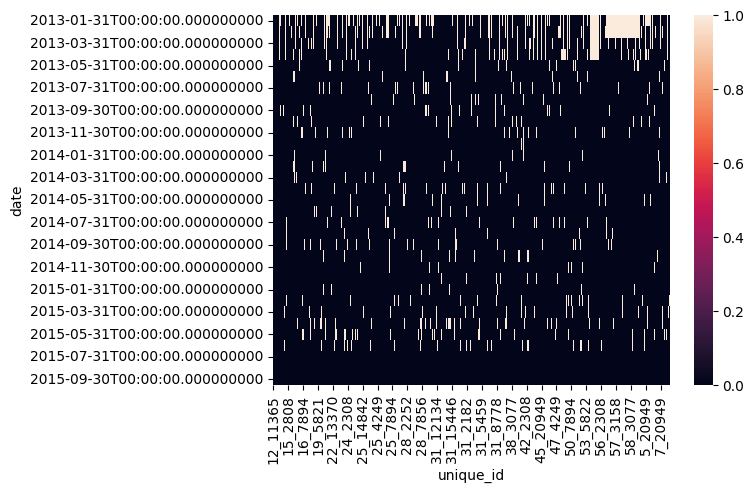

In [ ]:
# Check for null values.
# Where the price is null, we cannot set the price to 0. It doesn't make sense from a business perspective.
# What we are going to do is impute the price.
sns.heatmap(r)

In [ ]:
rr = (df
.pivot_table(
    index = "date",
    columns = "unique_id",
    values = "monthly_sales",
    aggfunc = lambda valor: valor
).isna()
)
# Create a pivot table to see where there are null values in the "monthly_sales" column. Save it and plot it.

<Axes: xlabel='unique_id', ylabel='date'>

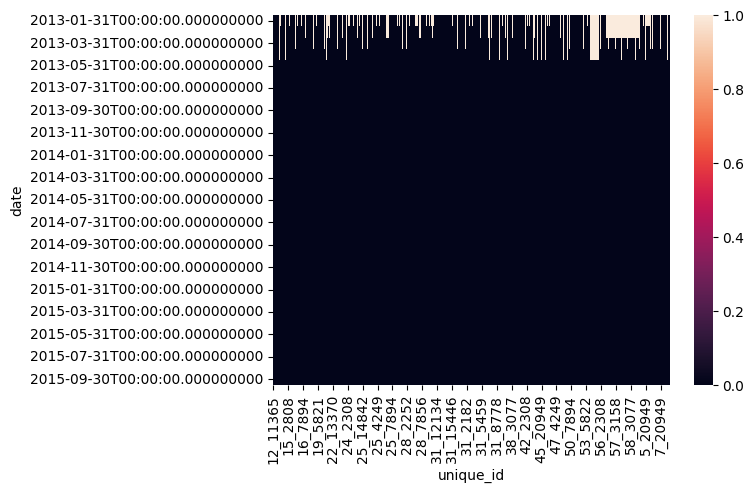

In [ ]:
# Check for null values.
# Null values in sales may simply mean that nothing has been sold. I will impute it with zero.
sns.heatmap(rr)

### Data Imputation


In [ ]:
#sample time series
sample_ts = "31_4249"

In [ ]:
# Note that the month of October is present in the dataset, but it has no sales. This is what we want to predict.

In [ ]:
#dataset of the sample time series
random_ts = df[df["unique_id"] == sample_ts]

In [1137]:
random_ts

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


In [ ]:
#checking ways of imputing price nulls
random_ts["monthly_average_price_bf_ff"] = random_ts["monthly_average_price"].bfill().ffill()
random_ts["monthly_average_price_interpolate"] = random_ts["monthly_average_price"].interpolate()

<ipython-input-1138-8b38e9e88180>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_ts["monthly_average_price_bf_ff"] = random_ts["monthly_average_price"].bfill().ffill()
<ipython-input-1138-8b38e9e88180>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_ts["monthly_average_price_interpolate"] = random_ts["monthly_average_price"].interpolate()


In [1139]:
random_ts

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_average_price_bf_ff,monthly_average_price_interpolate
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0,1899.000000,1899.000000
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0,1599.000000,1599.000000
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0,1013.416000,1013.416000
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0,1598.900000,1598.900000
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0,1598.937500,1598.937500
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0,1599.000000,1599.000000
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0,1399.000000,1399.000000
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0,1599.000000,1599.000000
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0,1199.000000,1199.000000
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0,929.075000,929.075000


In [ ]:
df.fillna({"monthly_sales":0}, inplace = True)
#impute nulls inmonthly sales with 0

In [ ]:
# We are going to impute the null values using bfill/ffill, grouped by unique_id. First, a backfill is performed, and if there are still nulls, a forward fill (ffill) is applied.

df["monthly_average_price"] = df.groupby("unique_id", group_keys = False)["monthly_average_price"].apply(
    lambda series: series.bfill().ffill()
)

In [1143]:
df.isnull().sum()

,0
date,0
unique_id,0
city_id,0
shop_id,0
item_category_id,0
item_id,0
monthly_average_price,0
monthly_sales,0


In [1144]:
df.sort_values(["unique_id", "date"], ascending = True, inplace = True)

In [1145]:
df[df["unique_id"] == sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


In [1146]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0


### EDA


In [1147]:
df.sample(15)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
3301,2013-05-31,25_5820,7,25,35,5820,1999.000000,1.0
6036,2013-06-30,31_20949,7,31,71,20949,4.998039,30.0
12970,2013-07-31,58_12134,22,58,30,12134,299.000000,4.0
3609,2014-02-28,25_11655,7,25,41,11655,1999.000000,1.0
11914,2013-02-28,56_7893,1,56,6,7893,1990.000000,4.0
2415,2014-08-31,22_17717,7,22,79,17717,976.166667,14.0
4099,2015-03-31,25_16169,7,25,65,16169,297.420000,12.0
1889,2013-07-31,21_5822,7,21,35,5822,1049.000000,3.0
3368,2013-07-31,25_2574,7,25,55,2574,399.000000,20.0
2977,2014-12-31,24_2445,7,24,30,2445,599.000000,6.0


### Analysis of Individual Time Series

### --> 1. EDA: Global Sales


In [1148]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

In [1149]:
y = df.set_index("date").resample("M")["monthly_sales"].sum()[:-1] # quitamos los registros de octubre

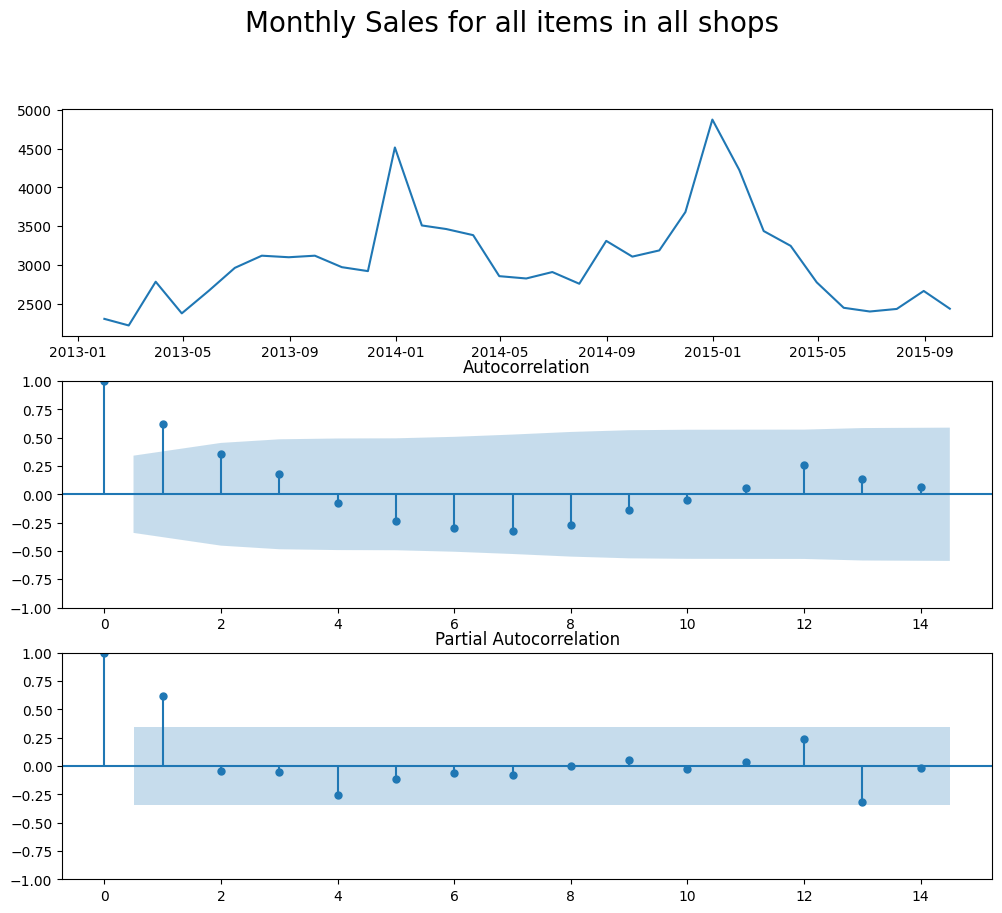

In [1150]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

### --> 2. EDA: Top 3 Cities


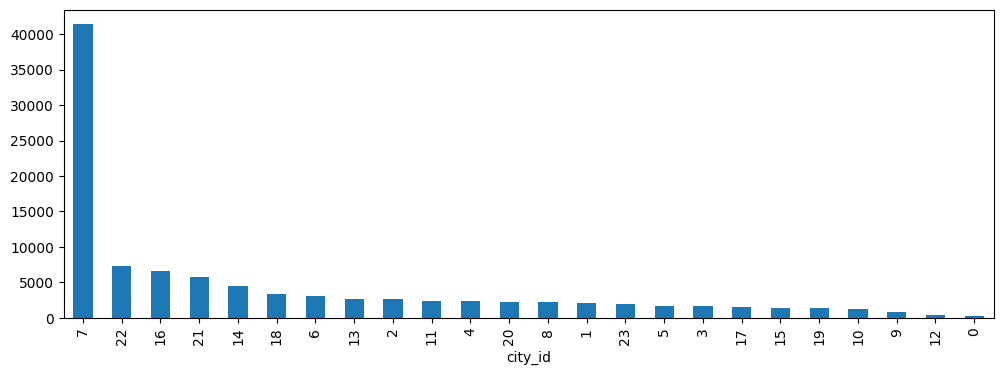

In [1151]:

(
    df.
    groupby(["city_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

### --> 3. EDA: Top 3 Categories

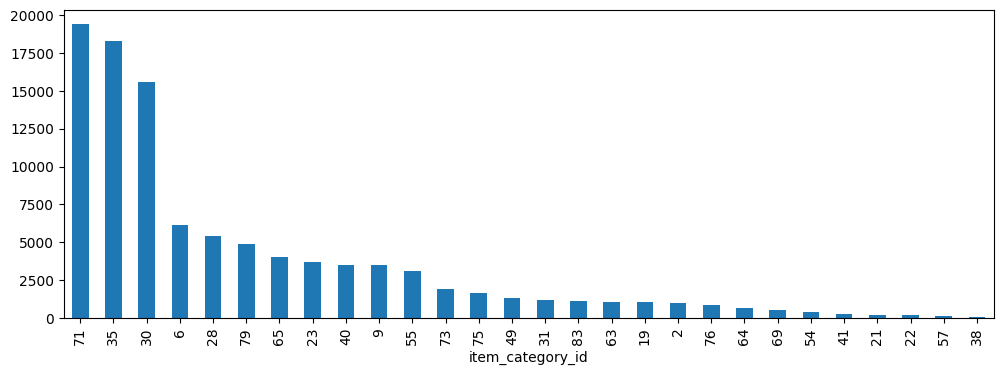

In [1152]:
(
    df.
    groupby(["item_category_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

### --> 4. EDA: item_category with more monthly income in september 2015

In [ ]:

df["unique_id_monthly_income"] = df["monthly_sales"] * df["monthly_average_price"]
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,unique_id_monthly_income
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500


In [ ]:

df[df["date"] == "2015-09-30"].groupby("item_category_id")["unique_id_monthly_income"].sum().sort_values(ascending = False)

,unique_id_monthly_income
item_category_id,
35,825643.728571
79,254546.902376
6,228514.083333
75,106170.000000
9,94139.653495
30,90001.875000
73,83680.416667
28,74185.025000
23,65890.580000


### --> 5. EDA: Category with the highest number of different item_ids.

In [ ]:


df.groupby("item_category_id")["item_id"].nunique().sort_values(ascending = False)

,item_id
item_category_id,
40,24
55,19
30,12
49,9
65,8
63,7
31,6
75,5
23,5


### Feature Engineering

In [ ]:
# Total sales per month _ lag 1
df["monthly_sales_total_month"] = df.groupby("date")["monthly_sales"].transform("sum")
df[df["date"] == "2013-01-31"].head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,unique_id_monthly_income,monthly_sales_total_month
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,2303.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0,17181.458333,2303.0
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0,20993.303571,2303.0
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0,3293.400000,2303.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0,1050.000000,2303.0


In [1157]:
df["monthly_sales_total_previous_month"] = df.groupby("unique_id")["monthly_sales_total_month"].shift(1)
df[df["date"] == "2013-02-28"].head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,unique_id_monthly_income,monthly_sales_total_month,monthly_sales_total_previous_month
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,2218.0,2303.0
8,2013-02-28,12_11369,16,12,9,11369,699.837037,30.0,20995.111111,2218.0,2303.0
9,2013-02-28,12_11370,16,12,9,11370,815.639589,30.0,24469.187675,2218.0,2303.0
10,2013-02-28,12_11373,16,12,9,11373,179.500000,2.0,359.000000,2218.0,2303.0
11,2013-02-28,12_12231,16,12,49,12231,350.000000,2.0,700.000000,2218.0,2303.0


In [ ]:
#calculate the 3-month moving average of the total purchases (by unique_id)
df["monthly_sales_total_month_ma_3"] = df.groupby("unique_id")["monthly_sales_total_month"].rolling(window = 3).mean().reset_index(level=0, drop=True)
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,unique_id_monthly_income,monthly_sales_total_month,monthly_sales_total_previous_month,monthly_sales_total_month_ma_3
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,2303.0,NaN,NaN
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,2218.0,2303.0,NaN
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,2782.0,2218.0,2434.333333
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091,2374.0,2782.0,2458.000000
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500,2665.0,2374.0,2607.000000


In [ ]:
#calculate the 3-month moving average of the total purchases (by unique_id) and shift(1)
df["monthly_sales_total_month_ma_3_lag1"] = df.groupby("unique_id")["monthly_sales_total_month_ma_3"].shift(1)
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,unique_id_monthly_income,monthly_sales_total_month,monthly_sales_total_previous_month,monthly_sales_total_month_ma_3,monthly_sales_total_month_ma_3_lag1
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,2303.0,NaN,NaN,NaN
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,2218.0,2303.0,NaN,NaN
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,2782.0,2218.0,2434.333333,NaN
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091,2374.0,2782.0,2458.000000,2434.333333
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500,2665.0,2374.0,2607.000000,2458.000000


In [1160]:
#mes con el mayor numero de ventas
df.groupby("date")["monthly_sales"].sum().sort_values(ascending = False)

,monthly_sales
date,
2014-12-31,4874.0
2013-12-31,4514.0
2015-01-31,4223.0
2014-11-30,3681.0
2014-01-31,3508.0
2014-02-28,3462.0
2015-02-28,3436.0
2014-03-31,3383.0
2014-08-31,3309.0


In [1161]:
df.drop([ "monthly_sales_total_month_ma_3", "monthly_sales_total_month"], axis = 1, inplace = True)

In [1162]:
df.sample(15)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,unique_id_monthly_income,monthly_sales_total_previous_month,monthly_sales_total_month_ma_3_lag1
4789,2013-06-30,28_6185,7,28,30,6185,499.00,7.0,3493.0,2665.0,2607.000000
6320,2013-10-31,31_12860,7,31,40,12860,149.00,4.0,596.0,3118.0,3111.333333
13144,2014-07-31,58_4244,22,58,23,4244,765.75,10.0,7657.5,2907.0,2861.666667
4246,2015-07-31,25_16167,7,25,64,16167,799.00,3.0,2397.0,2398.0,2539.333333
11413,2014-06-30,53_5822,18,53,35,5822,1049.00,17.0,17833.0,2824.0,3020.333333
6792,2014-04-30,31_15446,7,31,63,15446,499.00,8.0,3992.0,3383.0,3451.000000
3469,2013-10-31,25_16167,7,25,64,16167,632.52,5.0,3162.6,3118.0,3111.333333
12881,2015-10-31,57_6497,22,57,28,6497,1249.00,0.0,0.0,2434.0,2509.333333
6945,2014-06-30,31_15438,7,31,63,15438,629.00,7.0,4403.0,2824.0,3020.333333
629,2014-09-30,15_7893,2,15,6,7893,1790.00,1.0,1790.0,3309.0,2990.666667


In [ ]:
# Function to create new variables using groupby and aggregated functions.

In [1164]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name):

    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    gb_df_[f"{new_name}_lag1"] = gb_df_.groupby(gb_list)[new_name].transform( # para que entrene con las ventas del mes anterior, porque si no la variable es autoexplicativa.
        lambda series: series.shift(1)
    )

    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [1165]:
def build_ts_vars_lag2(df, gb_list, target_column, agg_func, agg_func_name):

    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    gb_df_[f"{new_name}_lag2"] = gb_df_.groupby(gb_list)[new_name].transform( # para que entrene con las ventas del mes anterior, porque si no la variable es autoexplicativa.
        lambda series: series.shift(2)
    )

    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [1166]:
#funcion diff
def build_ts_vars_diff(df, gb_list, target_column, agg_func, agg_func_name):

    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    gb_df_[f"{new_name}_diff_lag1"] = gb_df_.groupby(gb_list)[new_name].transform( # para que entrene con las ventas del mes anterior, porque si no la variable es autoexplicativa.
        lambda series: series.diff().shift(1)
    )

    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [ ]:
# Create columns for monthly_sales per unique_id from the previous month.
# df["unique_id_monthly_sales_lag1"]
df["unique_id_monthly_sales_lag1"] = df.groupby("unique_id")["monthly_sales"].shift(1)

In [1168]:
df.columns


Index(['date', 'unique_id', 'city_id', 'shop_id', 'item_category_id',
       'item_id', 'monthly_average_price', 'monthly_sales',
       'unique_id_monthly_income', 'monthly_sales_total_previous_month',
       'monthly_sales_total_month_ma_3_lag1', 'unique_id_monthly_sales_lag1'],
      dtype='object')

In [ ]:
# Create column for net margin by item_id from the previous month.
df_temp = df.groupby(['item_id', 'date']).agg({
    'monthly_sales': 'sum',
    'monthly_average_price': 'mean'
}).reset_index()
df_temp["monthly_income_item_id"] = df_temp["monthly_sales"] * df_temp["monthly_average_price"]
df_temp = df_temp.sort_values(by=['item_id', 'date'])
df_temp["monthly_income_item_id_lag1"] = df_temp.groupby('item_id')['monthly_income_item_id'].shift(1)
df_temp["monthly_sales_item_id_lag1"] = df_temp.groupby('item_id')['monthly_sales'].shift(1)

df_temp["monthly_average_price_item_id_lag1"] = df_temp.groupby('item_id')['monthly_average_price'].shift(1)

df_temp.drop(["monthly_sales", "monthly_average_price", "monthly_income_item_id"], axis = 1, inplace = True)
df_temp

,item_id,date,monthly_income_item_id_lag1,monthly_sales_item_id_lag1,monthly_average_price_item_id_lag1
0,32,2013-01-31,NaN,NaN,NaN
1,32,2013-02-28,8376.0,24.0,349.0
2,32,2013-03-31,6980.0,20.0,349.0
3,32,2013-04-30,4537.0,13.0,349.0
4,32,2013-05-31,3839.0,11.0,349.0
...,...,...,...,...,...
4483,22088,2015-06-30,2023.0,17.0,119.0
4484,22088,2015-07-31,1190.0,10.0,119.0
4485,22088,2015-08-31,2380.0,20.0,119.0
4486,22088,2015-09-30,2856.0,24.0,119.0


In [1170]:
'''
#crear columnas monthly_sales por unique_id del mes pasado.
#df["unique_id_monthly_sales_lag1"]
df["unique_id_monthly_sales_lag2"] = df.groupby("unique_id")["monthly_sales"].shift(2)
'''

'\n#crear columnas monthly_sales por unique_id del mes pasado.\n#df["unique_id_monthly_sales_lag1"]\ndf["unique_id_monthly_sales_lag2"] = df.groupby("unique_id")["monthly_sales"].shift(2)\n'

In [1171]:
'''
#crear columna unique_id_monthly_income_lag1

df["unique_id_monthly_income_lag1"] = df.groupby("unique_id")["unique_id_monthly_income"].shift(1)
'''

'\n#crear columna unique_id_monthly_income_lag1\n\ndf["unique_id_monthly_income_lag1"] = df.groupby("unique_id")["unique_id_monthly_income"].shift(1)\n'

In [1172]:
'''
#crear columna monthly_average_price_lag1 por unique_id
df["monthly_average_price_lag1"] = df.groupby("unique_id")["monthly_average_price"].shift(1)
'''

'\n#crear columna monthly_average_price_lag1 por unique_id\ndf["monthly_average_price_lag1"] = df.groupby("unique_id")["monthly_average_price"].shift(1)\n'

In [ ]:
# Create column for sales by category and store from the previous month.
df.groupby(["shop_id", "item_category_id", "date"])["monthly_sales"].sum().reset_index()

,shop_id,item_category_id,date,monthly_sales
0,3,6,2013-01-31,1.0
1,3,6,2013-02-28,0.0
2,3,6,2013-03-31,0.0
3,3,6,2013-04-30,0.0
4,3,6,2013-05-31,1.0
...,...,...,...,...
6999,59,83,2015-06-30,5.0
7000,59,83,2015-07-31,12.0
7001,59,83,2015-08-31,9.0
7002,59,83,2015-09-30,4.0


In [1174]:
df[df["unique_id"]==	"12_11365"].head(12)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,unique_id_monthly_income,monthly_sales_total_previous_month,monthly_sales_total_month_ma_3_lag1,unique_id_monthly_sales_lag1
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,NaN,NaN,NaN
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,2303.0,NaN,30.0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,2218.0,NaN,27.0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091,2782.0,2434.333333,30.0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500,2374.0,2458.000000,27.0
35,2013-06-30,12_11365,16,12,9,11365,1302.343750,28.0,36465.625000,2665.0,2607.000000,30.0
42,2013-07-31,12_11365,16,12,9,11365,1736.785714,20.0,34735.714286,2961.0,2666.666667,28.0
49,2013-08-31,12_11365,16,12,9,11365,3072.361111,16.0,49157.777778,3118.0,2914.666667,20.0
56,2013-09-30,12_11365,16,12,9,11365,9305.121212,24.0,223322.909091,3098.0,3059.000000,16.0
63,2013-10-31,12_11365,16,12,9,11365,2493.113360,30.0,74793.400810,3118.0,3111.333333,24.0


In [1175]:
df.groupby(["shop_id", "item_id"])["monthly_sales"].sum().reset_index()

,shop_id,item_id,monthly_sales
0,3,5822,161.0
1,3,7894,85.0
2,4,1905,178.0
3,4,2252,82.0
4,4,2308,171.0
...,...,...,...
421,59,2445,180.0
422,59,2808,253.0
423,59,20949,876.0
424,59,22087,206.0


In [1176]:
#probar...
#mes y ano en numeros
#diferencia de ventas un mes.
#diferencia de precio un mes.
#media movil de monthly income.

In [1177]:
#mes
df['month'] = df['date'].dt.month

In [1178]:
#ano
df['year'] = df['date'].dt.year

In [1179]:
#quarter
df['quarter'] = df['date'].dt.quarter

In [1180]:
#seno y coseno del mes (para que diciembre y enero esten cerca el uno del otro): no mejora
#df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
#df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [1181]:
df.columns

Index(['date', 'unique_id', 'city_id', 'shop_id', 'item_category_id',
       'item_id', 'monthly_average_price', 'monthly_sales',
       'unique_id_monthly_income', 'monthly_sales_total_previous_month',
       'monthly_sales_total_month_ma_3_lag1', 'unique_id_monthly_sales_lag1',
       'month', 'year', 'quarter'],
      dtype='object')

In [1182]:
#suma acumulada de las ventas por mes.(no mejora) ##
#df['sales_per_month_in_year_lag1'] = df.groupby(["date",'item_id', 'year'])['monthly_sales'].cumsum().shift(1)

In [1183]:
#shop_category_sales_ratio: Proporción de ventas de un producto en una tienda en comparación con las ventas totales de la categoría en esa tienda. Esto puede capturar la popularidad relativa de un producto en una tienda específica.

df['shop_category_sales_ratio_lag1'] = df['monthly_sales'] / df.groupby(["date", 'shop_id', 'item_category_id'])['monthly_sales'].transform('sum')

In [1184]:
df['shop_category_sales_ratio_lag1'] = df.groupby(["date", 'shop_id', 'item_category_id'])['shop_category_sales_ratio_lag1'].shift(1)


In [1185]:
#crear variable item_id_monthly_sales_sum_diff (no mejora)
#crear variable 	unique_id_monthly_average_price_mean_diff_lag1

GB_LIST_4 = ["unique_id" ]
TARGET_COLUMN = 'monthly_average_price'
AGG_FUNC = np.mean
AGG_FUNC_NAME = "mean"

vars_ts_4 = build_ts_vars_diff(
    df = df,
    gb_list = GB_LIST_4,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)

vars_ts_4.head(20)


<ipython-input-1166-449e29cf3fec>:13: FutureWarning: The provided callable <function mean at 0x7ab74cf1bd90> is currently using DatetimeIndexResamplerGroupby.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .apply(agg_func)


Dropping columns that might cause target leakage unique_id_monthly_average_price_mean


,unique_id,date,unique_id_monthly_average_price_mean_diff_lag1
0,12_11365,2013-01-31,NaN
1,12_11365,2013-02-28,NaN
2,12_11365,2013-03-31,21.612374
3,12_11365,2013-04-30,1719.345238
4,12_11365,2013-05-31,-1661.955087
5,12_11365,2013-06-30,-142.983902
6,12_11365,2013-07-31,-145.187500
7,12_11365,2013-08-31,434.441964
8,12_11365,2013-09-30,1335.575397
9,12_11365,2013-10-31,6232.760101


In [1186]:
df.groupby(["unique_id", "date"])['monthly_average_price'].mean()

unique_id  date      
12_11365   2013-01-31    1511.512626
           2013-02-28    1533.125000
           2013-03-31    3252.470238
           2013-04-30    1590.515152
           2013-05-31    1447.531250
                            ...     
7_7893     2015-06-30    2490.000000
           2015-07-31    2690.000000
           2015-08-31    2490.000000
           2015-09-30    2689.900000
           2015-10-31    2689.900000
Name: monthly_average_price, Length: 14484, dtype: float64

In [1187]:
#crear variable monthly_income del mes pasado por ciudad y categoria (mejor score)
GB_LIST_3 = ["city_id", 'item_category_id' ]
TARGET_COLUMN = "unique_id_monthly_income"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_3 = build_ts_vars(
    df = df,
    gb_list = GB_LIST_3,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)

vars_ts_3.head(20)

<ipython-input-1164-d08bac7bf300>:12: FutureWarning: The provided callable <function sum at 0x7ab74cf1ae60> is currently using DatetimeIndexResamplerGroupby.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .apply(agg_func)


Dropping columns that might cause target leakage city_id_item_category_id_unique_id_monthly_income_sum


,city_id,item_category_id,date,city_id_item_category_id_unique_id_monthly_income_sum_lag1
0,0,6,2013-01-31,NaN
1,0,6,2013-02-28,1490.0
2,0,6,2013-03-31,0.0
3,0,6,2013-04-30,0.0
4,0,6,2013-05-31,0.0
5,0,6,2013-06-30,1490.0
6,0,6,2013-07-31,4469.9
7,0,6,2013-08-31,2980.0
8,0,6,2013-09-30,8493.0
9,0,6,2013-10-31,8940.0


In [1188]:
#crear variable precio medio  por item id mes anterior
GB_LIST_2 = ["item_id"]
TARGET_COLUMN = "monthly_average_price"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "mean"

vars_ts_2 = build_ts_vars(
    df = df,
    gb_list = GB_LIST_2,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)

vars_ts_2.head(20)

<ipython-input-1164-d08bac7bf300>:12: FutureWarning: The provided callable <function sum at 0x7ab74cf1ae60> is currently using DatetimeIndexResamplerGroupby.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .apply(agg_func)


Dropping columns that might cause target leakage item_id_monthly_average_price_mean


,item_id,date,item_id_monthly_average_price_mean_lag1
0,32,2013-01-31,NaN
1,32,2013-02-28,349.0
2,32,2013-03-31,349.0
3,32,2013-04-30,349.0
4,32,2013-05-31,349.0
5,32,2013-06-30,349.0
6,32,2013-07-31,349.0
7,32,2013-08-31,349.0
8,32,2013-09-30,349.0
9,32,2013-10-31,349.0


In [1189]:
#crear variable ventas totales por categoria y tienda del mes pasado
GB_LIST_1 = ["shop_id", "item_category_id"]
TARGET_COLUMN = "monthly_sales"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_1 = build_ts_vars(
    df = df,
    gb_list = GB_LIST_1,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)

vars_ts_1.head(10)

<ipython-input-1164-d08bac7bf300>:12: FutureWarning: The provided callable <function sum at 0x7ab74cf1ae60> is currently using DatetimeIndexResamplerGroupby.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .apply(agg_func)


Dropping columns that might cause target leakage shop_id_item_category_id_monthly_sales_sum


,shop_id,item_category_id,date,shop_id_item_category_id_monthly_sales_sum_lag1
0,3,6,2013-01-31,NaN
1,3,6,2013-02-28,1.0
2,3,6,2013-03-31,0.0
3,3,6,2013-04-30,0.0
4,3,6,2013-05-31,0.0
5,3,6,2013-06-30,1.0
6,3,6,2013-07-31,3.0
7,3,6,2013-08-31,2.0
8,3,6,2013-09-30,6.0
9,3,6,2013-10-31,6.0


In [1190]:
#crear variable ventas totales por item_id mes anterior
GB_LIST = ["item_id"]
TARGET_COLUMN = "monthly_sales"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)

vars_ts_.head(10)

<ipython-input-1164-d08bac7bf300>:12: FutureWarning: The provided callable <function sum at 0x7ab74cf1ae60> is currently using DatetimeIndexResamplerGroupby.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .apply(agg_func)


Dropping columns that might cause target leakage item_id_monthly_sales_sum


,item_id,date,item_id_monthly_sales_sum_lag1
0,32,2013-01-31,NaN
1,32,2013-02-28,24.0
2,32,2013-03-31,20.0
3,32,2013-04-30,13.0
4,32,2013-05-31,11.0
5,32,2013-06-30,6.0
6,32,2013-07-31,11.0
7,32,2013-08-31,10.0
8,32,2013-09-30,9.0
9,32,2013-10-31,2.0


### Join TS Features

In [1191]:
print(df.shape)

df = pd.merge(df, df_temp, on = ["date", "item_id"], how = "left")

print(df.shape)

(14484, 16)
(14484, 19)


In [1192]:
print(df.shape)

df = pd.merge(df, vars_ts_, on = ["date"] + GB_LIST, how = "left")

print(df.shape)

(14484, 19)
(14484, 20)


In [1193]:
print(df.shape)

df = pd.merge(df, vars_ts_1, on = ["date"] + GB_LIST_1, how = "left")

print(df.shape)

(14484, 20)
(14484, 21)


In [1194]:
print(df.shape)

df = pd.merge(df, vars_ts_2, on = ["date"] + GB_LIST_2, how = "left")

print(df.shape)

(14484, 21)
(14484, 22)


In [1195]:
print(df.shape)

df = pd.merge(df, vars_ts_3, on = ["date"] + GB_LIST_3, how = "left")

print(df.shape)

(14484, 22)
(14484, 23)


In [1196]:
print(df.shape)

df = pd.merge(df, vars_ts_4, on = ["date"] + GB_LIST_4, how = "left")

print(df.shape)

(14484, 23)
(14484, 24)


### Train Test Split

In [1197]:
df.columns.tolist()

['date',
 'unique_id',
 'city_id',
 'shop_id',
 'item_category_id',
 'item_id',
 'monthly_average_price',
 'monthly_sales',
 'unique_id_monthly_income',
 'monthly_sales_total_previous_month',
 'monthly_sales_total_month_ma_3_lag1',
 'unique_id_monthly_sales_lag1',
 'month',
 'year',
 'quarter',
 'shop_category_sales_ratio_lag1',
 'monthly_income_item_id_lag1',
 'monthly_sales_item_id_lag1',
 'monthly_average_price_item_id_lag1',
 'item_id_monthly_sales_sum_lag1',
 'shop_id_item_category_id_monthly_sales_sum_lag1',
 'item_id_monthly_average_price_mean_lag1',
 'city_id_item_category_id_unique_id_monthly_income_sum_lag1',
 'unique_id_monthly_average_price_mean_diff_lag1']

In [1198]:
COLUMNS_TO_DROP = ['unique_id_monthly_income'
]

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [1199]:
df.set_index("unique_id", inplace = True)

In [1200]:
df.sample(5)

,date,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_sales_total_previous_month,monthly_sales_total_month_ma_3_lag1,unique_id_monthly_sales_lag1,...,quarter,shop_category_sales_ratio_lag1,monthly_income_item_id_lag1,monthly_sales_item_id_lag1,monthly_average_price_item_id_lag1,item_id_monthly_sales_sum_lag1,shop_id_item_category_id_monthly_sales_sum_lag1,item_id_monthly_average_price_mean_lag1,city_id_item_category_id_unique_id_monthly_income_sum_lag1,unique_id_monthly_average_price_mean_diff_lag1
unique_id,,,,,,,,,,,,,,,,,,,,,
22_20949,2015-09-30,7,22,71,20949,5.000000,30.0,2663.0,2497.333333,30.0,...,3,NaN,3168.908987,634.0,4.998279,634.0,30.0,114.960421,749.042458,-0.028986
26_17717,2013-10-31,7,26,79,17717,413.375000,7.0,3118.0,3111.333333,1.0,...,4,NaN,16086.024306,35.0,459.600694,35.0,1.0,5515.208333,5027.125000,0.000000
31_2445,2014-10-31,7,31,30,2445,598.833333,3.0,3106.0,3057.000000,19.0,...,4,0.310811,19917.039437,39.0,510.693319,39.0,78.0,3064.159913,72218.249982,37.625330
46_7894,2013-09-30,11,46,6,7894,1407.222222,9.0,3098.0,3059.000000,5.0,...,3,NaN,163284.134722,111.0,1471.028241,111.0,5.0,26478.508333,7450.000000,0.000000
25_6185,2014-06-30,7,25,30,6185,498.875000,0.0,2824.0,3020.333333,5.0,...,2,0.176471,15968.000000,32.0,499.000000,32.0,15.0,3992.000000,72473.816667,0.000000


In [1201]:
train_index = sorted(list(df["date"].unique()))[:-2]

valida_index = [sorted(list(df["date"].unique()))[-2]]

test_index = [sorted(list(df["date"].unique()))[-1]]

In [1202]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00')] - ... - [Timestamp('2015-07-31 00:00:00'), Timestamp('2015-08-31 00:00:00')]

Our validation index is [Timestamp('2015-09-30 00:00:00')]

Our test/prediction index is [Timestamp('2015-10-31 00:00:00')]



In [1203]:
X_train = df[df["date"].isin(train_index)].drop(['monthly_sales', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['monthly_sales']

X_valida = df[df["date"].isin(valida_index)].drop(['monthly_sales', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['monthly_sales']

X_test = df[df["date"].isin(test_index)].drop(['monthly_sales', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['monthly_sales']

### Model Train


In [1204]:
model = xgb.XGBRegressor(eval_metric = "rmse", seed = 175)

model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = True)

[0]	validation_0-rmse:6.29472	validation_1-rmse:5.81551
[1]	validation_0-rmse:5.28060	validation_1-rmse:4.74858
[2]	validation_0-rmse:4.66794	validation_1-rmse:4.16384
[3]	validation_0-rmse:4.30005	validation_1-rmse:3.80993
[4]	validation_0-rmse:4.07138	validation_1-rmse:3.59810
[5]	validation_0-rmse:3.90795	validation_1-rmse:3.45309
[6]	validation_0-rmse:3.77348	validation_1-rmse:3.42308
[7]	validation_0-rmse:3.67510	validation_1-rmse:3.33299
[8]	validation_0-rmse:3.60626	validation_1-rmse:3.31280
[9]	validation_0-rmse:3.55994	validation_1-rmse:3.28704
[10]	validation_0-rmse:3.51824	validation_1-rmse:3.28582
[11]	validation_0-rmse:3.45975	validation_1-rmse:3.27006
[12]	validation_0-rmse:3.40143	validation_1-rmse:3.32721
[13]	validation_0-rmse:3.37058	validation_1-rmse:3.34547
[14]	validation_0-rmse:3.33834	validation_1-rmse:3.38434
[15]	validation_0-rmse:3.30204	validation_1-rmse:3.37933
[16]	validation_0-rmse:3.27674	validation_1-rmse:3.36619
[17]	validation_0-rmse:3.24231	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Model Evaluation

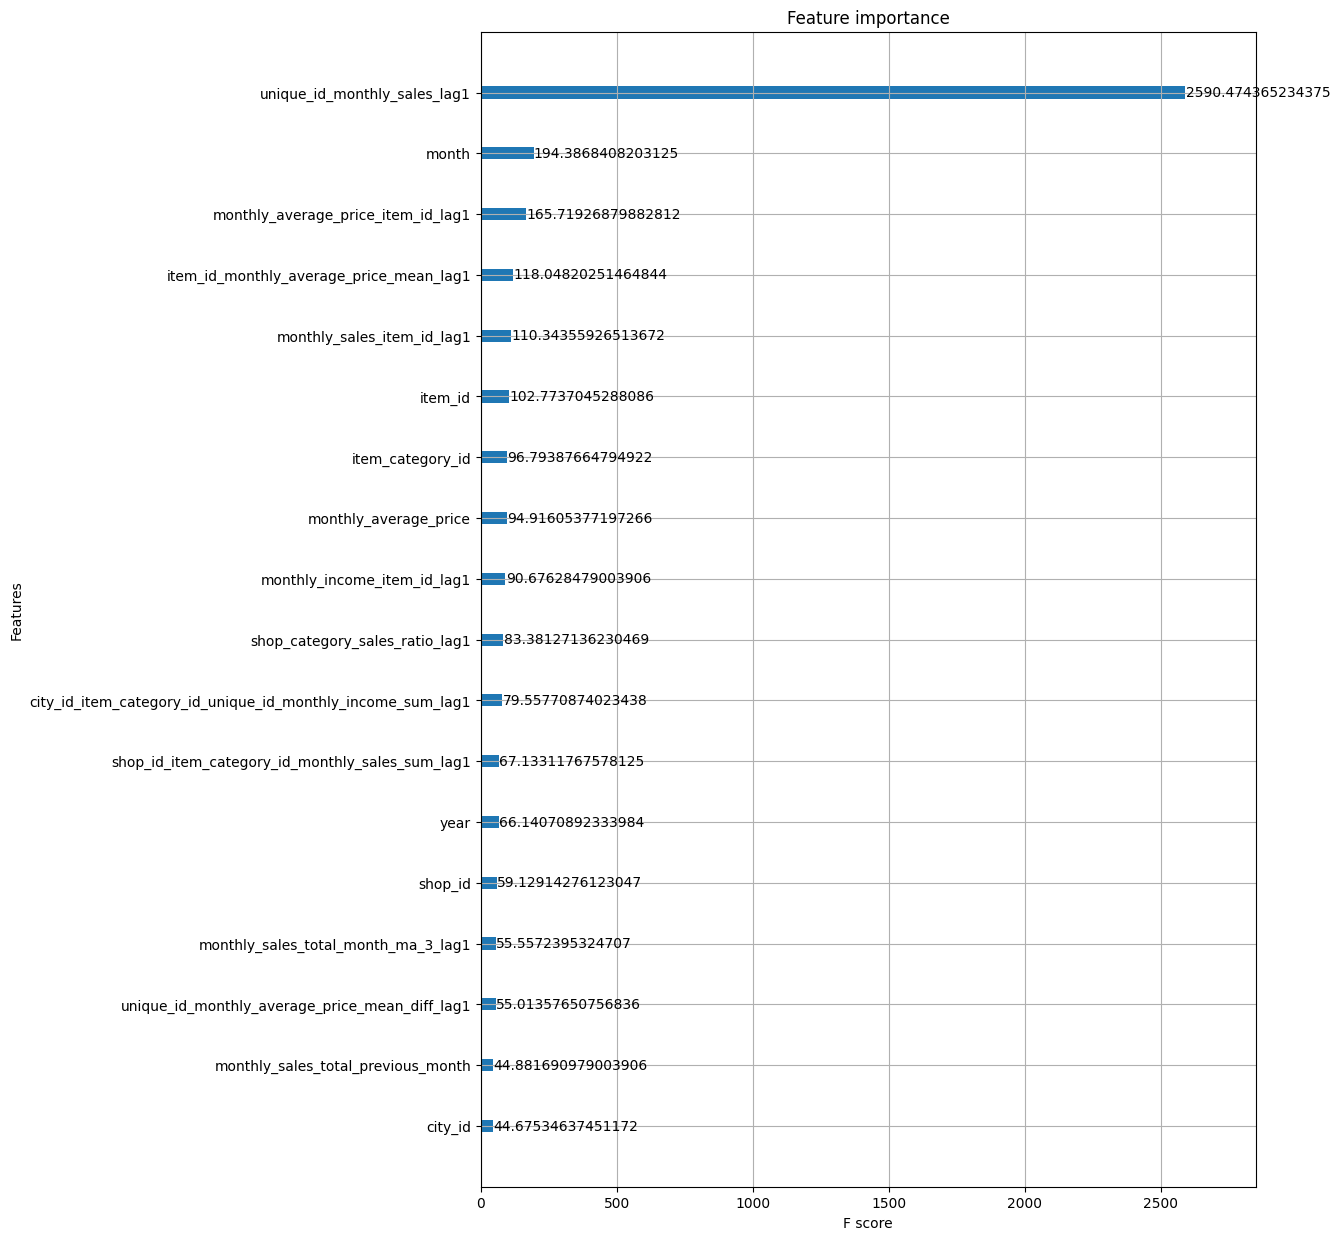

In [1205]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

### Prediction

In [1206]:
if "monthly_sales" in X_test.columns:
    X_test.drop("monthly_sales", axis = 1, inplace = True)

Y_test_predict = model.predict(X_test)
X_test["monthly_sales"] = Y_test_predict

In [1207]:
X_test.reset_index(inplace = True)

In [1208]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [1209]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 2_105
Validation RMSE: 3_168


In [ ]:
# Kaggle submission
(
    X_test[["unique_id", "monthly_sales"]]
    .to_csv(f"submission_train_{rmse_train}_valida_{rmse_valida}.csv", index = False)
)